# Centroids-and-Scatterplot.ipynb

In [22]:
#!/usr/bin/env python
'''File name: Centroids-and-Scatterplot.py
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 16.04.2018
    Date last modified: 16.04.2018

    ############################################################## 
    Purpos:

    Apply the optimal settings for the region of interest that was
    determined with:
    ~/papers/Extreme-WTs-US/programs/Extreme-WTs/SearchOptimum_ExtremeEvent-WeatherTyping.py

    1) Read the PRISM and ERA-Interim data
    2) Calculate the WT centroids
    3) Plot the Centroids
    3) Calculate Eucledian Distances for each day
    4) Plot ED vs. PR accumulation

'''

from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
from mpl_toolkits import basemap
# import ESMF
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
# from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile

from Functions_Extreme_WTs import XWT
from Functions_Extreme_WTs import MRR, MRD, perkins_skill
from Functions_Extreme_WTs import PreprocessWTdata
from Functions_Extreme_WTs import Centroids_to_NetCDF

# mpl.use('Agg')

def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

In [24]:
# ###################################################
# Get the setup for the XWTing
Season='JJASO' # ['AMJJAS', 'ONDJFM']
iReg= 3 #str("%02d" % int(sys.argv[1])) # str("%02d" % int(1)) #str("%02d" % int(sys.argv[1]))
Region=3 #str(iReg)+'/WBDHU2' # ['01/WBDHU2']


from HUC2_XWTs_apply_PL_FLX_combination import HUC2_XWTs_apply
rgdTime, iMonths, sPlotDir, Region, sDataDir, sSubregionPR, rgsWTvars, VarsFullName,rgsWTfolders, rgrNrOfExtremes, WT_Domains, DomDegreeAdd, Annual_Cycle, SpatialSmoothing, Metrics, Dimensions, ClusterMeth, ClusterBreakup, RelAnnom, NormalizeData, MinDistDD, RemoveAnnualCycl = HUC2_XWTs_apply(Season,Region)

if rgrNrOfExtremes > len(rgdTime):
    rgrNrOfExtremes = len(rgdTime)

# rgrNrOfExtremes=int(rgrNrOfExtremes*2)  # since split sample is done on half record
sSubregionPR=sSubregionPR+Region
# create nessesary directories
if not os.path.exists(sDataDir):
    os.makedirs(sDataDir)
if not os.path.exists(sPlotDir):
    os.makedirs(sPlotDir)
sRegion=Region.replace('/','-')

YYYY_stamp=str(rgdTime.year[0])+'-'+str(rgdTime.year[-1])
ss='-'
VarsJoint=ss.join(VarsFullName)
sMonths=ss.join([str(iMonths[ii]) for ii in range(len(iMonths))])
rgiSeasonWT=np.isin(rgdTime.month, iMonths)
rgiYears=np.unique(rgdTime.year)
rgdTime=rgdTime[rgiSeasonWT]
SPLIT=np.where(rgdTime.year <= rgiYears[int(len(rgiYears)/2)])[0][-1]


sPlotDir=sPlotDir+sRegion+'/'
if not os.path.exists(sPlotDir):
    os.makedirs(sPlotDir)

print( str(rgrNrOfExtremes)+' EXTREMES')
iNrOfExtremes=rgrNrOfExtremes   # we consider the N highest rainfall extremes


# ###################################################
#       READ IN SHAPEFILE
ncid=Dataset('/glade/campaign/mmm/c3we/prein/observations/PRISM/data/PR/PRISM_daily_ppt_2014.nc', mode='r') # open the netcdf file
rgrLatPR=np.squeeze(ncid.variables['lat'][:])
rgrLonPR=np.squeeze(ncid.variables['lon'][:])
ncid.close()


rgrGridCells=[(rgrLonPR.ravel()[ii],rgrLatPR.ravel()[ii]) for ii in range(len(rgrLonPR.ravel()))]
rgrSRactP=np.zeros((rgrLonPR.shape[0]*rgrLonPR.shape[1]))

if len(Region) == 4:
    # Arizona
    sSubregionPR = sSubregionPR[:-4]+'NHD_H_'+Region+'_HU4_Shape/Shape/WBDHU4'
    sf = shp.Reader(sSubregionPR)
    df = read_shapefile(sf)
    for sf in range(df.shape[0]):
        ctr = df['coords'][sf]
        if len(ctr) > 10000:
            ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
        else:
            ctr=np.array(ctr)
        grPRregion=mplPath.Path(ctr)
        TMP=np.array(grPRregion.contains_points(rgrGridCells))
    rgrSRactP[TMP == 1]=1
else:
    # New Mexico
    sSubregionPR='/glade/campaign/mmm/c3we/prein/Shapefiles/HUC6/NewMexico/HUC6'
    sf = shp.Reader(sSubregionPR)
    df = read_shapefile(sf)
    for sf in [iReg]: #range(df.shape[0]):
        ctr = df['coords'][sf]
        if len(ctr) > 10000:
            ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
        else:
            ctr=np.array(ctr)
        grPRregion=mplPath.Path(ctr)
        TMP=np.array(grPRregion.contains_points(rgrGridCells))
    rgrSRactP[TMP == 1]=1
rgrSRactP=np.reshape(rgrSRactP, (rgrLatPR.shape[0], rgrLatPR.shape[1]))

DomainSizes=['S','M','L','XXL']
DomDegreeAdd=[2,5,10,20]
DomDelta=DomDegreeAdd[DomainSizes.index(WT_Domains)]

Wlon=ctr[:,0].min()
Elon=ctr[:,0].max()
Nlat=ctr[:,1].max()
Slat=ctr[:,1].min()
DomainWT=np.array([[Elon+DomDelta,Slat-DomDelta],
                   [Wlon-DomDelta,Slat-DomDelta],
                   [Wlon-DomDelta,Nlat+DomDelta],
                   [Elon+DomDelta,Nlat+DomDelta],
                   [Elon+DomDelta,Slat-DomDelta]])
grWTregion=mplPath.Path(DomainWT)

# ###################################################
#         Read the PRISM grid and data
sPRsave=sDataDir+'Precipitation-Records_'+str(iNrOfExtremes)+'_'+sRegion+'_'+YYYY_stamp+'_'+sMonths
if os.path.isfile(sPRsave+'.npz')  == 0:
    from Functions_Extreme_WTs import ReadPRISM
    rgrPRrecords, rgiExtremePR, PR_Full = ReadPRISM(rgiYears,        # array containing the years that should be read
                                           iNrOfExtremes,   # number of extreme events
                                           rgiSeasonWT,     # months that should be processed
                                           iMonths,         # array of months that should be read in
                                           grPRregion)      # shapefile that contains target region

    np.savez(sPRsave, rgrPRrecords=rgrPRrecords, rgiExtremePR=rgiExtremePR,PR_Full=PR_Full)
else:
    print( '    Restore: '+sPRsave+'.npz')
    npzfile = np.load(sPRsave+'.npz')
    rgrPRrecords=npzfile['rgrPRrecords']
    rgiExtremePR=npzfile['rgiExtremePR']
    PR_Full=npzfile['PR_Full']

rgiExtremeDays=rgdTime[rgiExtremePR]


# ###################################################
# ###################################################
#             PERFORM CLUSTER ANALYSIS
sClusterSave=sDataDir+'Clusters'+str(iNrOfExtremes)+'_'+sRegion+'_'+YYYY_stamp+'_'+VarsJoint+'_'+Season
if os.path.isfile(sClusterSave)  == 0:
    # ###################################################
    #         Read the ERA-Interim grid and data

    from Functions_Extreme_WTs import ReadERAI
    DailyVarsOrig, LonWT, LatWT=ReadERAI(grWTregion,        # shapefile with WTing region
                                         rgdTime,           # time period for WTing
                                         iMonths,           # list of months that should be considered
                                         rgsWTfolders,      # directories containing WT files
                                         rgsWTvars)         # netcdf variable names of WT variables
    # run split sample thest and derive centroids of full dataset
    Samples=['SS1',"SS2","Full"]
    grClustersFin={}
    grEucledianDist={}
    grCorrelation={}
    grPSS={}
    grMRD={}
    grMRR={}
    grExluded={}
    grAPR={}
    grAUC={}
    for ss in range(len(Samples)):
        print('    Split Sample '+Samples[ss])
        if ss == 0:
            DailyVarsTrain=DailyVarsOrig[:SPLIT,:]
            DailyVarsEval=DailyVarsOrig[-SPLIT:,:]
            Ptrain=PR_Full[:SPLIT]
            Peval=PR_Full[-SPLIT:]
            TimeTrain=rgdTime[:SPLIT]
            TimeEval=rgdTime[-SPLIT:]
        elif ss == 1:
            DailyVarsTrain=DailyVarsOrig[-SPLIT:,:]
            DailyVarsEval=DailyVarsOrig[:SPLIT,:]
            Ptrain=PR_Full[-SPLIT:]
            Peval=PR_Full[:SPLIT]
            TimeTrain=rgdTime[-SPLIT:]
            TimeEval=rgdTime[:SPLIT]
        elif ss == 2:
            DailyVarsTrain=DailyVarsOrig
            DailyVarsEval=DailyVarsOrig
            Ptrain=PR_Full
            Peval=PR_Full
            TimeTrain=rgdTime
            TimeEval=rgdTime
        if iNrOfExtremes > len(TimeEval):
            iExtrNr = len(TimeEval)
        else:
            iExtrNr = iNrOfExtremes

        XWT_output=XWT(DailyVarsTrain,
            DailyVarsEval,
            Ptrain,
            Peval,
            TimeTrain,
            TimeEval,
            iExtrNr,
            SpatialSmoothing,
            ClusterMeth=ClusterMeth,
            ClusterBreakup=ClusterBreakup,
            RelAnnom=RelAnnom,
            NormalizeData=NormalizeData,
            MinDistDD=MinDistDD,
            RemoveAnnualCycl=RemoveAnnualCycl)

        # ################################################
        # ######       EUCLEDIAN DISTANCES
        try:
            EucledianDist=XWT_output['EucledianDistAllWTs']
            Correlation =XWT_output['grCorrelatioAllWTs']
            rgrClustersFin=XWT_output['grClustersFin']
        except:
            continue

        NetCDFname=sDataDir+sRegion+'_XWT-centroids_train-'+str(TimeTrain.year[0])+'-'+str(TimeTrain.year[-1])+'_eval-'+str(TimeEval.year[0])+'-'+str(TimeEval.year[-1])+'_E'+str("%03d" % iNrOfExtremes)+'_XWTs'+str(rgrClustersFin[1].max()+1)+'_Vars-'+VarsJoint+'_M-'+sMonths+'.nc'
        print('    save: '+NetCDFname)
        Centroids_to_NetCDF(NetCDFname,
                        XWT_output,
                        LonWT,
                        LatWT,
                        DailyVarsTrain,
                        rgdTime,
                        TimeEval,
                        VarsJoint,
                        rgiExtremeDays)

        from Functions_Extreme_WTs import Scatter_ED_PR
        MinDistance=np.min(EucledianDist, axis=1)
        ClosestWT=np.argmin(EucledianDist, axis=1)
        MaxCorr=np.max(Correlation, axis=1)
#         Scatter_ED_PR(MinDistance,
#                       ClosestWT,
#                       np.nanmean(Peval, axis=1),
#                       rgrNrOfExtremes,
#                       PlotLoc=sPlotDir,
#                       PlotName='Scatter_'+sRegion+'_NrExt-'+str(rgrNrOfExtremes)+'_Smooth-'+str(SpatialSmoothing)+'_AnnCy-'+Annual_Cycle+'_'+VarsJoint+'_'+sMonths+'_'+Samples[ss]+'.pdf')

        # Perkins Skill Score
        grPSS[Samples[ss]]=XWT_output['grPSS']
        # Mean relative difference
        grMRD[Samples[ss]]=XWT_output['grMRD']
        # Mean Rank Ratio
        grMRR[Samples[ss]]=XWT_output['grMRR']
        # % of days excluded
        grExluded[Samples[ss]]=XWT_output['PEX']
        # % of days excluded
        grAPR[Samples[ss]]=XWT_output['APR']
        # % of days excluded
        grAUC[Samples[ss]]=XWT_output['AUC'] 

        # save the data
        grClustersFin[Samples[ss]]=XWT_output['grClustersFin']
        grEucledianDist[Samples[ss]]=XWT_output['grEucledianDist']
        grCorrelation[Samples[ss]]=XWT_output['grCorrelatio']

    DATAcollection={'grClustersFin':grClustersFin, 
                    'grEucledianDist': grEucledianDist, 
                    'grCorrelatio':grCorrelation,
                    'grPSS':grPSS,
                    'grMRD':grMRD,
                    'grMRR':grMRR,
                    'grExluded':grExluded,
                    'grAPR':grAPR,
                    'grAUC':grAUC,
                    'LonWT':LonWT,
                    'LatWT':LatWT,
                    'iReg':iReg,
                    'VarsFullName':VarsFullName,
                    'rgrNrOfExtremes':rgrNrOfExtremes,
                    'WT_Domains':WT_Domains,
                    'SpatialSmoothing':SpatialSmoothing,
                    'MinDistance':MinDistance,
                    'Peval':Peval,
                    'rgdTime':rgdTime}

    with open(sClusterSave, 'wb') as handle:
        pickle.dump(DATAcollection, handle)
else:
    print( '    Restore: '+sClusterSave)
with open(sClusterSave, 'rb') as handle:
    npzfile = pickle.load(handle)

grClustersFin=npzfile['grClustersFin']
grEucledianDist=npzfile['grEucledianDist']
grCorrelation=npzfile['grCorrelatio']
LonWT=npzfile['LonWT']
LatWT=npzfile['LatWT']

rgrClustersFin=grClustersFin['Full']
EucledianDist=grEucledianDist['Full']
Correlation=grCorrelation['Full']



# sort the clusters according to the number of days to ensure that the
# same pattern is at the same location for different event sample sizes
rgiClustSize=[sum(rgrClustersFin[1] == cc) for cc in range(rgrClustersFin[1].max()+1)]
rgiSorted=np.argsort(rgiClustSize)
rgiSorted=range(len(rgiSorted))

13514 EXTREMES
        Read ERA-I year: 1982
        Read ERA-I year: 1983
        Read ERA-I year: 1984
        Read ERA-I year: 1985
        Read ERA-I year: 1986
        Read ERA-I year: 1987
        Read ERA-I year: 1988
        Read ERA-I year: 1989
        Read ERA-I year: 1990
        Read ERA-I year: 1991
        Read ERA-I year: 1992
        Read ERA-I year: 1993
        Read ERA-I year: 1994
        Read ERA-I year: 1995
        Read ERA-I year: 1996
        Read ERA-I year: 1997
        Read ERA-I year: 1998
        Read ERA-I year: 1999
        Read ERA-I year: 2000
        Read ERA-I year: 2001
        Read ERA-I year: 2002
        Read ERA-I year: 2003
        Read ERA-I year: 2004
        Read ERA-I year: 2005
        Read ERA-I year: 2006
        Read ERA-I year: 2007
        Read ERA-I year: 2008
        Read ERA-I year: 2009
        Read ERA-I year: 2010
        Read ERA-I year: 2011
        Read ERA-I year: 2012
        Read ERA-I year: 2013
        Read ERA-I year: 

        Read ERA-I year: 1982
        Read ERA-I year: 1983
        Read ERA-I year: 1984
        Read ERA-I year: 1985
        Read ERA-I year: 1986
        Read ERA-I year: 1987
        Read ERA-I year: 1988
        Read ERA-I year: 1989
        Read ERA-I year: 1990
        Read ERA-I year: 1991
        Read ERA-I year: 1992
        Read ERA-I year: 1993
        Read ERA-I year: 1994
        Read ERA-I year: 1995
        Read ERA-I year: 1996
        Read ERA-I year: 1997
        Read ERA-I year: 1998
        Read ERA-I year: 1999
        Read ERA-I year: 2000
        Read ERA-I year: 2001
        Read ERA-I year: 2002
        Read ERA-I year: 2003
        Read ERA-I year: 2004
        Read ERA-I year: 2005
        Read ERA-I year: 2006
        Read ERA-I year: 2007
        Read ERA-I year: 2008
        Read ERA-I year: 2009
        Read ERA-I year: 2010
        Read ERA-I year: 2011
        Read ERA-I year: 2012
        Read ERA-I year: 2013
        Read ERA-I year: 2014
        Re

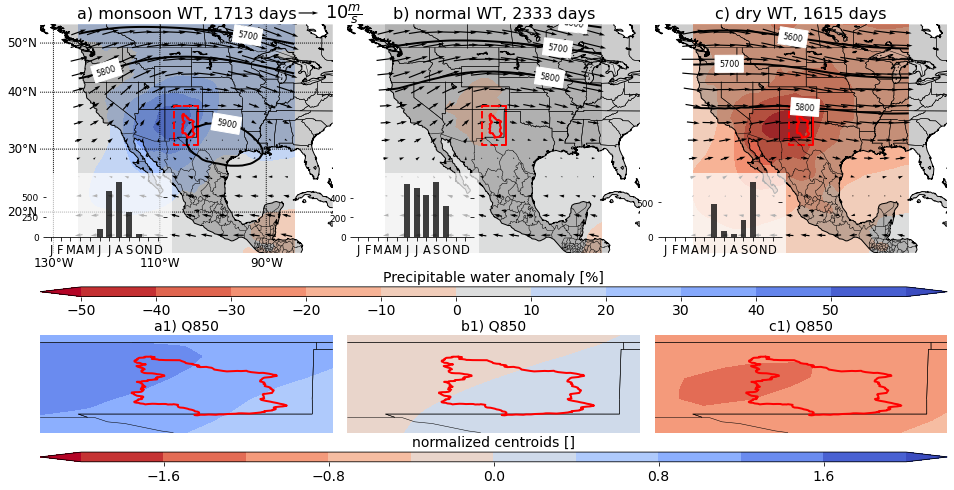

In [25]:
# ### Plot the synoptic setup and the centroids
# WT histograms
rgrClustersFin = grClustersFin['Full']
WTnr = rgrClustersFin[1].max()
MonthlyWTfreq = np.zeros((12,WTnr+1))
for wt in range(WTnr+1):
    TimeTMP = rgdTime[rgrClustersFin[1] == wt]
    for mo in range(12):
        MonthlyWTfreq[mo,wt] = np.sum(TimeTMP.month == (mo+1))
# plt.plot(MonthlyWTfreq); plt.show()


from Functions_Extreme_WTs import add_subplot_axes

rgsWTvarsA=['z','u','v','tcw']
rgsWTfoldersA=['/glade/campaign/mmm/c3we/prein/ERA-Interim/Z500/Z500_daymean_',              
               '/glade/campaign/mmm/c3we/prein/ERA-Interim/UV500/UV500_daymean_',              
               '/glade/campaign/mmm/c3we/prein/ERA-Interim/UV500/UV500_daymean_',              
               '/glade/campaign/mmm/c3we/prein/ERA-Interim/TCW/fin_TCW-sfc_ERA-Interim_12-0_']
# start reading in the precipitation from PRISM for a larger region
iRegionPlus=30 # grid cell added around shape rectangle
ncid=Dataset('/glade/scratch/prein/ERA-Interim/PSL/fin_PSL-sfc_ERA-Interim_12-0_2014.nc', mode='r') # open the netcdf file
rgrLatWT1D=np.squeeze(ncid.variables['lat'][:])
rgrLonWT1D=np.squeeze(ncid.variables['lon'][:])
ncid.close()
rgrLonWT=np.asarray(([rgrLonWT1D,]*rgrLatWT1D.shape[0]))
rgrLonWT[rgrLonWT > 180]=rgrLonWT[rgrLonWT > 180]-360
rgrLatWT=np.asarray(([rgrLatWT1D,]*rgrLonWT1D.shape[0])).transpose()
rgrGridCells=[(rgrLonWT.ravel()[ii],rgrLatWT.ravel()[ii]) for ii in range(len(rgrLonWT.ravel()))]
rgrSRact=np.array(grWTregion.contains_points(rgrGridCells)); rgrSRact=np.reshape(rgrSRact, (rgrLatWT.shape[0], rgrLatWT.shape[1]))
rgiSrWT=np.array(np.where(rgrSRact == True))
iLatMax=rgiSrWT[0,:].max()+iRegionPlus
iLatMin=rgiSrWT[0,:].min()-iRegionPlus
iLonMax=rgiSrWT[1,:].max()+iRegionPlus
iLonMin=rgiSrWT[1,:].min()-iRegionPlus
rgrLatWT_SR=rgrLatWT[iLatMin:iLatMax,iLonMin:iLonMax]
rgrLonWT_SR=rgrLonWT[iLatMin:iLatMax,iLonMin:iLonMax]

DomDelta=20
Wlon=ctr[:,0].min()
Elon=ctr[:,0].max()
Nlat=ctr[:,1].max()
Slat=ctr[:,1].min()
DomainWT=np.array([[Elon+DomDelta,Slat-DomDelta],
                   [Wlon-DomDelta,Slat-DomDelta],
                   [Wlon-DomDelta,Nlat+DomDelta],
                   [Elon+DomDelta,Nlat+DomDelta],
                   [Elon+DomDelta,Slat-DomDelta]])
grWTregion=mplPath.Path(DomainWT)
from Functions_Extreme_WTs import ReadERAI
rgrWTdata, rgrLonWT, rgrLatWT=ReadERAI(grWTregion,        # shapefile with WTing region
                                 rgdTime,           # time period for WTing
                                 iMonths,           # list of months that should be considered
                                 rgsWTfoldersA,      # directories containing WT files
                                 rgsWTvarsA)         # netcdf variable names of WT variables

# average over the WTs
rgrWTcentroids=np.zeros((rgrClustersFin[1].max()+1,rgrWTdata.shape[1],rgrWTdata.shape[2],rgrWTdata.shape[3])); rgrWTcentroids[:]=np.nan
for cc in range(rgrClustersFin[1].max()+1):
    rgiClAct=(rgrClustersFin[1] == (cc))
    try:
        rgrWTcentroids[cc,:]=np.mean(rgrWTdata[rgiClAct,:,:,:], axis=0)
    except:
        stop()

# Calculate the geometry of the plot dependent on how many panels there are
import math
PanWidth=4 # cm
PanHeight=2.5 # cm
xdist=0.5
ydist=0.5
Panels=rgrClustersFin[1].max()+1
iColums=np.min([4,Panels])
iRows=np.max([1,int((math.ceil(Panels/4.)))])
iXX=[0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]
iYY=[0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]

X_Fig=PanWidth*iColums+xdist*(iColums+1)
Y_Fig=PanHeight*iRows+(iRows+1)

plt.rcParams.update({'font.size': 18})
rgsLableABC=list(string.ascii_lowercase)
fig = plt.figure(figsize=(X_Fig,Y_Fig*1.5))
gs1 = gridspec.GridSpec(iRows,iColums)
gs1.update(left=0.05, right=0.95,
           bottom=0.47, top=0.94,
           wspace=0.05, hspace=0.20)
# rllcrnrlat,urcrnrlat,llcrnrlon,urcrnrlon=np.min(rgrLatPR_SR),np.max(rgrLatPR_SR),np.min(rgrLatPR_SR),np.max(rgrLatPR_SR)
dLat=((52-25)/2.)*1.5
dLon=(130-75)/2.
rllcrnrlat=np.mean((rgrLatWT_SR.min(),rgrLatWT_SR.max()))-dLat #      25 #rllcrnrlat-(urcrnrlat-rllcrnrlat)*0.03
urcrnrlat=np.mean((rgrLatWT_SR.min(),rgrLatWT_SR.max()))+dLat      #52 #urcrnrlat+(urcrnrlat-rllcrnrlat)*0.01
llcrnrlon=np.mean((rgrLonWT_SR.min(),rgrLonWT_SR.max()))-dLon #    -130 #llcrnrlon-abs(llcrnrlon-urcrnrlon)*0.01
urcrnrlon=np.mean((rgrLonWT_SR.min(),rgrLonWT_SR.max()))+dLon #     -75 #urcrnrlon+abs(llcrnrlon-urcrnrlon)*0.01

Wettness = np.nanmean(rgrWTcentroids[:,:,:,rgsWTvarsA.index('tcw')], axis=(1,2))
WT_names = np.array(['dry','normal','monsoon'])

for pa in range(Panels):
    WT_name_act = WT_names[np.argsort(Wettness) == pa][0]
    # define margins of subplot (see http://matplotlib.org/users/gridspec.html)
    iSampleSize=np.sum(rgrClustersFin[1] == pa)
    ax = plt.subplot(gs1[iYY[pa],iXX[pa]])
    try:
        m = Basemap(projection='cea',                    
                    llcrnrlat= rllcrnrlat ,urcrnrlat=urcrnrlat,                    
                    llcrnrlon=llcrnrlon,urcrnrlon=urcrnrlon,resolution='l', fix_aspect=False)
    except:
        stop()
    plt.axis('off')
    xi, yi = m(rgrLonWT, rgrLatWT)
    rgrColorTable=['#a50026','#d73027','#f46d43','#fdae61','#fee090','#ffffff','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695'][::-1]

    # plot PW anomalies
    iContNr=len(rgrColorTable)+1
    clevs=np.arange(-50,70,10)
    rgrDataAct=rgrWTcentroids[pa, :,:,rgsWTvarsA.index('tcw')]
    rgrDataAct = ((rgrDataAct-np.mean(rgrWTdata[:,:,:,rgsWTvarsA.index('tcw')],axis=0))/np.mean(rgrWTdata[:,:,:,rgsWTvarsA.index('tcw')],axis=0))*100.
    cs = m.contourf(xi,yi,rgrDataAct,clevs,cmap='coolwarm_r', extend='both', alpha=1, zlevel=20)
    # plot wind field
    iLev=1; iDist=4
    Q = plt.quiver(xi[::iDist, ::iDist],yi[::iDist, ::iDist],rgrWTcentroids[pa,::iDist,::iDist,1],
                   rgrWTcentroids[pa,::iDist,::iDist,2], units='width',zorder = 1, pivot='middle',width=0.004, scale=150)
    if pa == 0:
        qk = ax.quiverkey(Q, 0.95, 1.05, 10, r'$10 \frac{m}{s}$', labelpos='E') #,coordinates='figure')
    # plot geopotential height
    iContNr=20
    clevs=np.arange(0,100000,100)
    CS=m.contour(xi[:,:],yi[:,:],rgrWTcentroids[pa,:,:,rgsWTvarsA.index('z')]/9.81,levels=clevs.astype('int'),
                 colors='k',linewidths=2, zlevel=0) #['#d9f0a3','#addd8e','#78c679','#41ab5d','#238443','#005a32'])
    clabels=plt.clabel(CS, inline=1, fontsize=8, fmt='%d')
    [txt.set_backgroundcolor('white') for txt in clabels]
    # plot cluster region
    iLatMax=rgrLatWT1D[rgiSrWT[0,:].max()]
    iLatMin=rgrLatWT1D[rgiSrWT[0,:].min()]
    iLonMax=rgrLonWT1D[rgiSrWT[1,:].max()]
    iLonMin=rgrLonWT1D[rgiSrWT[1,:].min()]
    lats = [iLatMin, iLatMax, iLatMax, iLatMin,iLatMin]
    lons = np.array([iLonMin, iLonMin, iLonMax, iLonMax, iLonMin])-360
#     x, y = m(lons,lats)
#     m.plot(x,y, lw=2, ls='--', c='r', zorder=1)
    
    x, y = m(list(LonWT[0,:])+list(LonWT[:,0])+list(LonWT[-1,:])+list(LonWT[:,-1]), list(LatWT[0,:])+list(LatWT[:,0])+list(LatWT[-1,:])+list(LatWT[:,-1]))
    m.plot(x,y, lw=2, ls='--', c='r', zorder=1)

    # Lable the map
    plt.title(rgsLableABC[pa]+') '+WT_name_act+' WT, '+str(iSampleSize)+' days', fontsize=16)

    m.drawcoastlines(color='k')
    m.drawcountries(color='k')
    m.drawstates(color='k')
    m.fillcontinents(color='k',lake_color='white', alpha=0.2)
    # add shapefile of catchment
    XX,YY=m(ctr[:,0], ctr[:,1])
    m.plot(XX,YY, c='r', lw=2)
    
    if pa == 0:
        parallels = np.arange(0.,81,10.)
        # labels = [left,right,top,bottom]
        m.drawparallels(parallels,labels=[True,False,True,False], fontsize=12)
        meridians = np.arange(10.,351.,20.)
        m.drawmeridians(meridians,labels=[True,False,False,True], fontsize=12)

    # Add Histogram in the lower left corner
    rect = [0.02,0.07,0.4,0.25]
    from matplotlib.patches import Rectangle
    currentAxis = plt.gca()
    currentAxis.add_patch(Rectangle((0, 0), 0.45, 0.35, facecolor="white", transform = ax.transAxes, alpha=0.7,zorder = 100))
    
    ax1 = add_subplot_axes(ax,rect)
    # plt.axis('off')
    rgiMonths = np.array([rgdTime[rgrClustersFin[1] == pa][nn].month for nn in range(len(rgdTime[rgrClustersFin[1] == pa]))])
    ax1.hist(rgiMonths,np.array(range(1,14,1)), facecolor='k', alpha=0.75,rwidth=0.6)
    ax1.set_xticks(np.array(range(1,13,1))+0.5)
    ax1.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.xaxis.set_ticks_position('bottom')
    ax1.set_xlim([1,13])
    # ax2.yaxis.set_ticks_position('left')
    ax1.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        right='off',         # ticks along the top edge are off
        labelleft='off') # labels along the bottom edge are off
    ax1.patch.set_alpha(0.0)


    # ==========================================================================================
    # ==========================================================================================
    # plot the actual centroids for each WT
    LonWT=npzfile['LonWT']
    LatWT=npzfile['LatWT']
    pos1 = np.array(ax.get_position())
    gs2 = gridspec.GridSpec(1,len(rgsWTvars))
    gs2.update(left=pos1[0][0], right=pos1[1][0],
           bottom=0.10, top=0.30,
           wspace=0.05, hspace=0.20)
    for va in range(len(rgsWTvars)):
        ax = plt.subplot(gs2[0,va])
        CentroidsAct=rgrClustersFin[0][pa]
        CentroidsAct=np.reshape(CentroidsAct,(LonWT.shape[0],LonWT.shape[1],len(rgsWTvars)))
        m = Basemap(projection='cea',                    llcrnrlat= np.min(LatWT) ,urcrnrlat=np.max(LatWT),                    
                    llcrnrlon=np.min(LonWT),urcrnrlon=np.max(LonWT),resolution='l', fix_aspect=False)
        xi, yi = m(LonWT, LatWT)
        cs1= plt.contourf(xi, yi, CentroidsAct[:,:,va], cmap='coolwarm_r',levels=np.linspace(-2,2,11),extend='both')
        plt.axis('off')
        # add shapefile of catchment
        XX,YY=m(ctr[:,0], ctr[:,1])
        m.plot(XX,YY, c='r', lw=2)
#         m.drawcoastlines(color='k')
        m.drawcountries(color='k')
        m.drawstates(color='k')
        plt.title(rgsLableABC[pa]+str(int(va+1))+') '+VarsFullName[va], fontsize=14)

# add colorbar for IVT
CbarAx = plt.axes([0.05, 0.38, 0.9, 0.02])
cb = plt.colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both', ticks=np.arange(-50,60,10))
cb.ax.tick_params(labelsize=14)
cb.ax.set_title('Precipitable water anomaly [%]', fontsize=14)

# add colorbar for centroids
CbarAx = plt.axes([0.05, 0.04, 0.9, 0.02])
cb = plt.colorbar(cs1, cax = CbarAx, orientation='horizontal', extend='both') #, ticks=np.arange(300,1600,200))
cb.ax.tick_params(labelsize=14)
cb.ax.set_title('normalized centroids []', fontsize=14)

# Save the plot
# plt.show()
sPlotFile=sPlotDir
# sPlotName= 'BottomUp-'+str(rgrClustersFin[1].max()+1)+'WT_Centroids.pdf'
sPlotName= 'BottomUp_'+str("%03d" % iNrOfExtremes)+'_Events_'+str(rgrClustersFin[1].max()+1)+'WT_Centroids_'+YYYY_stamp+'_'+VarsJoint+'_'+sMonths+'.png'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)

### Plot the precipitation in WTs

        Plot map to: /glade/u/home/prein/projects/Arizona_WTing/plots/WT-CentroidsHUC6-03/BottomUp_13514_Events_3WT_precipitation_1982-2018_Q850_6-7-8-9-10.png


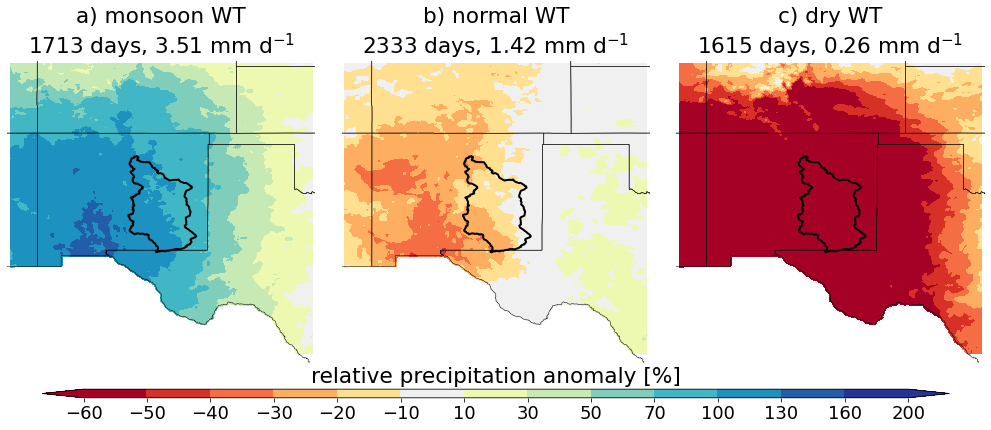

In [26]:
# # #############################################################################
# # ######             PLOT PRECIPITATION IN WTs
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile

# start reading in the precipitation from PRISM for a larger region
iRegionPlus=100 # grid cell added around shape rectangle
ncid=Dataset('/glade/campaign/mmm/c3we/prein/observations/PRISM/data/PR/PRISM_daily_ppt_2014.nc', mode='r') # open the netcdf file
rgrLatPR=np.squeeze(ncid.variables['lat'][:])
rgrLonPR=np.squeeze(ncid.variables['lon'][:])
ncid.close()
rgrGridCells=[(rgrLonPR.ravel()[ii],rgrLatPR.ravel()[ii]) for ii in range(len(rgrLonPR.ravel()))]
rgrSRact=np.array(grPRregion.contains_points(rgrGridCells)); rgrSRact=np.reshape(rgrSRact, (rgrLatPR.shape[0], rgrLatPR.shape[1]))
rgiSrPR=np.array(np.where(rgrSRact == True))
iLatMax=np.min([rgiSrPR[0,:].max()+100, rgrLatPR.shape[0]-1])
iLatMin=np.max([rgiSrPR[0,:].min()-100, 0])
iLonMax=np.min([rgiSrPR[1,:].max()+100, rgrLatPR.shape[1]-1])
iLonMin=np.max([rgiSrPR[1,:].min()-100, 0])
rgrLatPR_SR=rgrLatPR[iLatMin:iLatMax,iLonMin:iLonMax]
rgrLonPR_SR=rgrLonPR[iLatMin:iLatMax,iLonMin:iLonMax]
rgrPRdata=np.zeros((rgrNrOfExtremes,iLatMax-iLatMin,iLonMax-iLonMin)); rgrPRdata[:]=np.nan
jj=0

YEARSALL=np.unique(rgdTime.year)
rgrPRdata=np.zeros((len(rgdTime),iLatMax-iLatMin,iLonMax-iLonMin))
jj=0
for yy in range(len(rgiYears)):
    rgdTimeYY = pd.date_range(datetime.datetime(YEARSALL[yy], 1, 1), end=datetime.datetime(YEARSALL[yy], 12, 31), freq='d')
    rgiDD=np.where(((rgdTimeYY.year == YEARSALL[yy]) & (np.isin(rgdTimeYY.month, iMonths))))[0]
    ncid=Dataset('/glade/campaign/mmm/c3we/prein/observations/PRISM/data/PR/PRISM_daily_ppt_'+str(YEARSALL[yy])+'.nc', mode='r') # open the netcdf file
    rgrPRdata[jj:jj+len(rgiDD),:,:]=np.squeeze(ncid.variables['PR'][rgiDD,iLatMin:iLatMax,iLonMin:iLonMax])
    ncid.close()
    jj=jj+len(rgiDD)

rgrPRdata[rgrPRdata < 0]=np.nan



# precipitation in WTs
rgrPR_WTs=np.zeros((rgrClustersFin[1].max()+1,rgrPRdata.shape[1],rgrPRdata.shape[2])); rgrPR_WTs[:]=np.nan
for cc in range(rgrClustersFin[1].max()+1):
    rgiClAct=(rgrClustersFin[1] == (cc))
    try:
        rgrPR_WTs[cc,:]=np.nanmean(rgrPRdata[rgiClAct,:], axis=0)
    except:
        stop()


# In[27]:


# Calculate the geometry of the plot dependent on how many panels there are
PanWidth=4 # cm
PanHeight=4 # cm
xdist=0.5
ydist=0.5
Panels=rgrClustersFin[1].max()+1
iColums=np.min([4,Panels])
iRows=np.max([1,int((math.ceil(Panels/4.)))])
iXX=[0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]
iYY=[0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]

X_Fig=PanWidth*iColums+xdist*(iColums+1)
Y_Fig=PanHeight*iRows+(iRows+1)

plt.rcParams.update({'font.size': 18})
rgsLableABC=list(string.ascii_lowercase)

fig = plt.figure(figsize=(X_Fig,Y_Fig))
gs1 = gridspec.GridSpec(iRows,iColums)
gs1.update(left=0.01, right=0.99,
           bottom=0.15, top=0.85,
           wspace=0.05, hspace=0.15)
rllcrnrlat,urcrnrlat,llcrnrlon,urcrnrlon=np.min(rgrLatPR_SR),np.max(rgrLatPR_SR),np.min(rgrLonPR_SR),np.max(rgrLonPR_SR)
rllcrnrlat=rllcrnrlat-(urcrnrlat-rllcrnrlat)*0.03
urcrnrlat=urcrnrlat+(urcrnrlat-rllcrnrlat)*0.01
llcrnrlon=llcrnrlon-abs(llcrnrlon-urcrnrlon)*0.01
urcrnrlon=urcrnrlon+abs(llcrnrlon-urcrnrlon)*0.01
for pa in range(Panels):
    WT_name_act = WT_names[np.argsort(Wettness) == pa][0]
    # define margins of subplot (see http://matplotlib.org/users/gridspec.html)
    iSampleSize=np.sum(rgrClustersFin[1] == pa)
    ax = plt.subplot(gs1[iYY[pa],iXX[pa]])
    rAvPR=np.nanmean(rgrPRrecords[rgrClustersFin[1] == pa])
    rgrDataAct = np.nanmean(rgrPRdata[rgrClustersFin[1] == pa], axis=0)
    m = Basemap(projection='cea',                    
                llcrnrlat= rllcrnrlat ,urcrnrlat=urcrnrlat,                    
                llcrnrlon=llcrnrlon,urcrnrlon=urcrnrlon,resolution='i', fix_aspect=True)
    plt.axis('off')
    xi, yi = m(rgrLonPR_SR, rgrLatPR_SR)
    #Load ColorMap
    Colors = ['#a50026','#d73027','#f46d43','#fdae61','#fee090','#f0f0f0','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#253494','#081d58']
    clevs=np.arange(-100,120,20)  #np.append([0],clevs); clevs[1]=0.1
    clevs = [-60, -50,  -40,  -30, -20,-10, 10,30,50,70,100,130,160,200]
    rgrDataAct = ((rgrDataAct-np.mean(rgrPRdata, axis=0))/np.mean(rgrPRdata, axis=0))*100
    cs = m.contourf(xi,yi,rgrDataAct, clevs,colors=Colors, extend='both')
    # Lable the map
    plt.title(rgsLableABC[pa]+') '+WT_name_act+' WT\n'+str(iSampleSize)+' days, '+str(np.round(rAvPR,2))+' mm d$^{-1}$') #, fontsize=16)

    # plot US States
    sUSStates='/glade/u/home/prein/ShapeFiles/US-States/cb_2013_us_state_5m'
    m.readshapefile(sUSStates, 'Temp_sf', drawbounds=True, linewidth=0.5, color='k')

    # add shapefile of catchment
    XX,YY=m(ctr[:,0], ctr[:,1])
    m.plot(XX,YY, c='k', lw=2)

# add colorbar
CbarAx = axes([0.05, 0.07, 0.90, 0.02])
cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both', ticks=clevs)
cb.ax.set_title('relative precipitation anomaly [%]')


# Save the plot
# plt.show()
sPlotFile=sPlotDir
# sPlotName= 'BottomUp-'+str(rgrClustersFin[1].max()+1)+'WT_precipitation.pdf'
sPlotName= 'BottomUp_'+str("%03d" % iNrOfExtremes)+'_Events'+'_'+str(rgrClustersFin[1].max()+1)+'WT_precipitation'+'_'+YYYY_stamp+'_'+VarsJoint+'_'+sMonths+'.png'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)

### Plot Precipitation Statistics over Arizona

In [15]:
# # #############################################################################
# # ######             PLOT PRECIPITATION STATISTICS
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile

# start reading in the precipitation from PRISM for a larger region
iRegionPlus=100 # grid cell added around shape rectangle
ncid=Dataset('/glade/campaign/mmm/c3we/prein/observations/PRISM/data/PR/PRISM_daily_ppt_2014.nc', mode='r') # open the netcdf file
rgrLatPR=np.squeeze(ncid.variables['lat'][:])
rgrLonPR=np.squeeze(ncid.variables['lon'][:])
ncid.close()
rgrGridCells=[(rgrLonPR.ravel()[ii],rgrLatPR.ravel()[ii]) for ii in range(len(rgrLonPR.ravel()))]
rgrSRact=np.array(grPRregion.contains_points(rgrGridCells)); rgrSRact=np.reshape(rgrSRact, (rgrLatPR.shape[0], rgrLatPR.shape[1]))
rgiSrPR=np.array(np.where(rgrSRact == True))
iLatMax=np.min([rgiSrPR[0,:].max()+100, rgrLatPR.shape[0]-1])
iLatMin=np.max([rgiSrPR[0,:].min()-100, 0])
iLonMax=np.min([rgiSrPR[1,:].max()+100, rgrLatPR.shape[1]-1])
iLonMin=np.max([rgiSrPR[1,:].min()-100, 0])
rgrLatPR_SR=rgrLatPR[iLatMin:iLatMax,iLonMin:iLonMax]
rgrLonPR_SR=rgrLonPR[iLatMin:iLatMax,iLonMin:iLonMax]
rgrPRdata=np.zeros((rgrNrOfExtremes,iLatMax-iLatMin,iLonMax-iLonMin)); rgrPRdata[:]=np.nan
jj=0

dStartDayPR=datetime.datetime(1982, 1, 1,0)
dStopDayPR=datetime.datetime(2018, 12, 31,23)
rgdTimeYYall = pd.date_range(dStartDayPR, end=dStopDayPR, freq='d')
YEARSALL=np.unique(rgdTimeYYall.year)
rgrPRdata=np.zeros((len(rgdTimeYYall),iLatMax-iLatMin,iLonMax-iLonMin))
jj=0
for yy in range(len(rgiYears)):
    rgdTimeYY = pd.date_range(datetime.datetime(YEARSALL[yy], 1, 1), end=datetime.datetime(YEARSALL[yy], 12, 31), freq='d')
    rgiDD=np.where(((rgdTimeYY.year == YEARSALL[yy])))[0]
    ncid=Dataset('/glade/campaign/mmm/c3we/prein/observations/PRISM/data/PR/PRISM_daily_ppt_'+str(YEARSALL[yy])+'.nc', mode='r') # open the netcdf file
    rgrPRdata[jj:jj+len(rgiDD),:,:]=np.squeeze(ncid.variables['PR'][rgiDD,iLatMin:iLatMax,iLonMin:iLonMax])
    ncid.close()
    jj=jj+len(rgiDD)

rgrPRdata[rgrPRdata < 0]=np.nan

KeyboardInterrupt: 

In [ ]:
# # Calculate monthly averages
# PRmonths = np.zeros((len(rgiYears),12,rgrPRdata.shape[1],rgrPRdata.shape[2])); PRmonths[:] = np.nan
# for yy in range(len(rgiYears)):
#     for mm in range(12):
#         rgiDD=((rgdTimeYYall.year == YEARSALL[yy]) & (rgdTimeYYall.month == (mm+1)))
#         PRmonths[yy,mm,:,:] = np.mean(rgrPRdata[rgiDD,:,:], axis=0)

# plot bar chart with monthly mean precip over basin
MeanPRmon = np.nanmean(PRmonths[:,:,rgrSRactP[iLatMin:iLatMax,iLonMin:iLonMax]==1], axis=(0,2))
STDprMon = np.std(np.nanmean(PRmonths[:,:,rgrSRactP[iLatMin:iLatMax,iLonMin:iLonMax]==1], axis=(2)), axis=0)

 
# Make a fake dataset
height = [3, 12, 5, 18, 45]
bars = ('J', 'F', 'M', 'A', 'M','J','J','A','S','O','N','D')
y_pos = np.arange(len(MeanPRmon))
plt.bar(y_pos, MeanPRmon, color=(0.2, 0.4, 0.6, 0.6), yerr=STDprMon/2.)
plt.xticks(y_pos, bars)
plt.ylabel("Monthly mean\nprecipitation [mm d$^{-1}$]")
plt.show()


### Plot monthly mean precipitation maps

In [ ]:
Months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for mm in range(12):
    MeanPRmon = np.nanmean(PRmonths[:,mm,:], axis=(0))
    
    # Calculate the geometry of the plot dependent on how many panels there are
    plt.rcParams.update({'font.size': 18})
    rgsLableABC=list(string.ascii_lowercase)

    fig = plt.figure(figsize=(8,7))
    gs1 = gridspec.GridSpec(1,1)
    gs1.update(left=0.01, right=0.99,
               bottom=0.10, top=0.95,
               wspace=0.05, hspace=0.15)
    rllcrnrlat,urcrnrlat,llcrnrlon,urcrnrlon=np.min(rgrLatPR_SR),np.max(rgrLatPR_SR),np.min(rgrLonPR_SR),np.max(rgrLonPR_SR)
    rllcrnrlat=rllcrnrlat-(urcrnrlat-rllcrnrlat)*0.03
    urcrnrlat=urcrnrlat+(urcrnrlat-rllcrnrlat)*0.01
    llcrnrlon=llcrnrlon-abs(llcrnrlon-urcrnrlon)*0.01
    urcrnrlon=urcrnrlon+abs(llcrnrlon-urcrnrlon)*0.01

    # define margins of subplot (see http://matplotlib.org/users/gridspec.html)
    ax = plt.subplot(gs1[0,0])
    m = Basemap(projection='cea',                    
                llcrnrlat= rllcrnrlat ,urcrnrlat=urcrnrlat,                    
                llcrnrlon=llcrnrlon,urcrnrlon=urcrnrlon,resolution='i', fix_aspect=True)
    plt.axis('off')
    xi, yi = m(rgrLonPR_SR, rgrLatPR_SR)
    #Load ColorMap
    rgrColorTable=['#00eeef','#00a5f3','#0505ef','#00ff00','#03c502','#058c02','#fff707','#e6bd01','#ff8f08','#ff0000','#d90104','#b70500','#f107fe']
    clevs=np.arange(0,len(rgrColorTable)*0.5,0.5)
    
    rgrColorTable=np.append(['#ffffff'],rgrColorTable)
    cs = m.contourf(xi,yi,MeanPRmon,clevs,colors=rgrColorTable, extend='max')
    # Lable the map
    plt.title(Months[mm]+' monthly mean precipitation') #, fontsize=16)
    # plot US States
    sUSStates='/glade/u/home/prein/ShapeFiles/US-States/cb_2013_us_state_5m'
    m.readshapefile(sUSStates, 'Temp_sf', drawbounds=True, linewidth=0.5, color='k')

    # add shapefile of catchment
    XX,YY=m(ctr[:,0], ctr[:,1])
    m.plot(XX,YY, c='k', lw=2)

    # add colorbar
    CbarAx = axes([0.05, 0.20, 0.90, 0.02])
    cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both', ticks=clevs)
    cb.ax.set_title('precipitation [mm d$^{-1}$]')


    # Save the plot
    # plt.show()
    sPlotFile='/glade/u/home/prein/projects/Arizona_WTing/plots/PR-Statistics/'
    # sPlotName= 'BottomUp-'+str(rgrClustersFin[1].max()+1)+'WT_precipitation.pdf'
    sPlotName= str(mm+1).zfill(2)+'_PRISM_Lower-CO.png'
    if os.path.isdir(sPlotFile) != 1:
        subprocess.call(["mkdir","-p",sPlotFile])
    print( '        Plot map to: '+sPlotFile+sPlotName)
    fig.savefig(sPlotFile+sPlotName)

### Seasonal mean precip maps

In [ ]:
Stats = 'Jul-Oct'
MeanPRmon = np.nanmean(PRmonths[:,[6,7,8,9],:], axis=(0,1))
  
    
# Calculate the geometry of the plot dependent on how many panels there are
plt.rcParams.update({'font.size': 18})
rgsLableABC=list(string.ascii_lowercase)

fig = plt.figure(figsize=(8,7))
gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.01, right=0.99,
           bottom=0.10, top=0.95,
           wspace=0.05, hspace=0.15)
rllcrnrlat,urcrnrlat,llcrnrlon,urcrnrlon=np.min(rgrLatPR_SR),np.max(rgrLatPR_SR),np.min(rgrLonPR_SR),np.max(rgrLonPR_SR)
rllcrnrlat=rllcrnrlat-(urcrnrlat-rllcrnrlat)*0.03
urcrnrlat=urcrnrlat+(urcrnrlat-rllcrnrlat)*0.01
llcrnrlon=llcrnrlon-abs(llcrnrlon-urcrnrlon)*0.01
urcrnrlon=urcrnrlon+abs(llcrnrlon-urcrnrlon)*0.01

# define margins of subplot (see http://matplotlib.org/users/gridspec.html)
ax = plt.subplot(gs1[0,0])
m = Basemap(projection='cea',                    
            llcrnrlat= rllcrnrlat ,urcrnrlat=urcrnrlat,                    
            llcrnrlon=llcrnrlon,urcrnrlon=urcrnrlon,resolution='i', fix_aspect=True)
plt.axis('off')
xi, yi = m(rgrLonPR_SR, rgrLatPR_SR)
#Load ColorMap
rgrColorTable=['#00eeef','#00a5f3','#0505ef','#00ff00','#03c502','#058c02','#fff707','#e6bd01','#ff8f08','#ff0000','#d90104','#b70500','#f107fe']
clevs=np.arange(0,len(rgrColorTable)*0.3,0.3)

rgrColorTable=np.append(['#ffffff'],rgrColorTable)
cs = m.contourf(xi,yi,MeanPRmon,clevs,colors=rgrColorTable, extend='max')
# Lable the map
plt.title(Stats+' monthly mean precipitation') #, fontsize=16)
# plot US States
sUSStates='/glade/u/home/prein/ShapeFiles/US-States/cb_2013_us_state_5m'
m.readshapefile(sUSStates, 'Temp_sf', drawbounds=True, linewidth=0.5, color='k')

# add shapefile of catchment
XX,YY=m(ctr[:,0], ctr[:,1])
m.plot(XX,YY, c='k', lw=2)

# add colorbar
CbarAx = axes([0.05, 0.20, 0.90, 0.02])
cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both', ticks=clevs)
cb.ax.set_title('precipitation [mm d$^{-1}$]')

plt.show()

In [59]:
from dask.distributed import Client, progress
client = Client(threads_per_worker=4, n_workers=1)

In [60]:
client

Client Scheduler: tcp://127.0.0.1:34175 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 4 Memory: 322.12 GB
